In [1]:
import glob
import random
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense

from tqdm import tqdm
from PIL import Image

from tensorflow.keras.utils import to_categorical

import seaborn as sns
import matplotlib.image as img
import matplotlib.pyplot as plt
import platform

2024-08-19 17:56:26.429884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 17:56:26.520136: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 17:56:26.520726: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-19 17:56:26.645280: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-19 17:56:28.179524: W tensorflow/compiler/tf

In [2]:
if platform.system() == "Darwin":
    root_directory = '/Users/lorenzobarbiero/Documents/GitHub/human_pose'
    data_directory = '/Users/lorenzobarbiero/Desktop/Università/VCS/Human Action Recognition'
else:
    root_directory = ''
    data_directory = '../human_pose_local/archive/Human Action Recognition'

print('root directory is ' + root_directory)
print('data directory is ' + data_directory)

root directory is 
data directory is ../human_pose_local/archive/Human Action Recognition


In [3]:
train_df = pd.read_csv(data_directory + '/Training_set.csv')
test_df = pd.read_csv(data_directory + '/Testing_set.csv')

In [4]:
train_fol = glob.glob(data_directory + "/train/*")
test_fol = glob.glob(data_directory + "/test/*")

In [5]:
import plotly.express as px
HAR = train_df.label.value_counts()
fig = px.pie(train_df, values=HAR.values, names=HAR.index,title="Label Distribution")
fig.show()

In [6]:
filename = train_df['filename']
labels = train_df['label']

In [7]:
def displaying_random():
    num = random.randint(1, 10000)
    image_filename =  f"Image_{num}.jpg"
    img_path = data_directory + f"/train/{image_filename}"
    imgg = img.imread(img_path)
    plt.imshow(imgg)
    plt.title("{}".format(train_df.loc[train_df['filename'] == "{}".format(image_filename), 'label'].item()))
    plt.axis('off')
    plt.show()

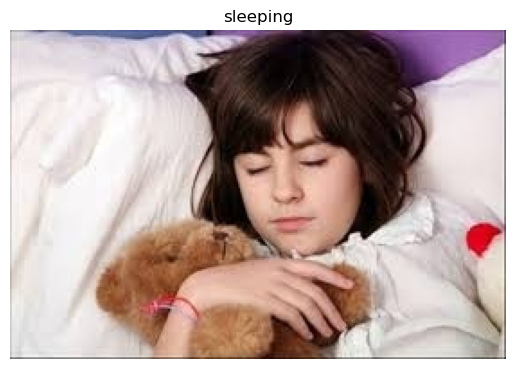

In [8]:
displaying_random()

In [9]:
image_data = []
image_label = []

for i in (range(len(train_fol)-1)):
    t = data_directory + '/train/' + filename[i]
    imgg = Image.open(t)
    image_data.append(np.asarray(imgg.resize((160,160))))
    image_label.append(labels[i])

In [10]:
iii = image_data
iii = np.asarray(iii)
type(iii)

numpy.ndarray

In [12]:
efficientnet_model = Sequential()

model = tf.keras.applications.EfficientNetB7(include_top=False,
                                            input_shape=(160,160,3),
                                            pooling ="avg",classes=15,
                                             weights="imagenet")

for layer in model.layers:
    layer.trainable=False


efficientnet_model.add(model)
efficientnet_model.add(Flatten())
efficientnet_model.add(Dense(512,activation="relu"))
efficientnet_model.add(Dense(15,activation="softmax"))

In [13]:
efficientnet_model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy'])

In [14]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix   
import time

def plot_train(results):
    
    train_loss = results.history['loss']
    val_loss = results.history['val_loss']
    train_accuracy = results.history['accuracy']
    val_accuracy = results.history['val_accuracy']
    
    t = np.arange(len(train_accuracy))
    
    print('Stopped at epoch ', len(train_accuracy))
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 5))

    ax1.plot(t, train_loss, 'b')
    ax1.set_title('Train loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')

    ax2.plot(t, val_loss, 'g')
    ax2.set_title('Validation loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')

    ax3.plot(t, train_accuracy, 'b')
    ax3.set_title('Training accuracy')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('Accuracy')

    ax4.plot(t, val_accuracy, 'g')
    ax4.set_title('Validation accuracy')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Accuracy')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Display the plot
    plt.show()

In [19]:
def create_dataset(iii, labels, batch_size = 32):
    
    input_shape = (160, 160, 3)
    
    dataset = tf.data.Dataset.from_tensor_slices((iii, labels))
    
    dataset = dataset.batch(batch_size = batch_size)
    
    return dataset, input_shape

In [20]:
labels = train_df['label'].factorize()[0]

In [21]:
create_dataset(iii, labels)

2024-08-19 17:59:56.325758: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 967680000 exceeds 10% of free system memory.


(<_BatchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 (160, 160, 3))

In [23]:
def train_test_split_df(df, test_perc): 
    
    n_classes = df['category'].nunique()
    
    n_samples = int(len(df)*test_perc/n_classes)
    
    test_df = df.groupby('category').apply(lambda x: x.sample(n_samples)).reset_index(drop=True)

    # split the dataframe in train and test by the column 'filename'

    train_df = df[~df['filename'].isin(test_df['filename'])]
    
    return train_df, test_df

In [24]:
# Number of folds
n_splits = 5
batch_s = 32
index = 1

# KFold cross-validation
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

accuracy_per_fold = []
conf_matrix = np.zeros((15,15))


for train_index, val_index in kf.split(train_df):
    
    print("Starting Fold Number ", index)
    print()
    
    index += 1      
    
    df_train, df_val = iii[train_index], iii[val_index]
    
    # Convert to TensorFlow datasets
    train_dataset, inp_shape = create_dataset(df_train, batch_s)
    val_dataset, _ = create_dataset(df_val, batch_s)
    
    print("Fitting the model:")
    print()
    
    start = time.time()
    
    early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

    results = efficientnet_model.fit(train_dataset,
                        epochs=1000,
                        validation_data=val_dataset, 
                        callbacks=[early_stop_callback], verbose = 0)

    end = time.time()
    print('Training time: ', round(end-start,2), " s")
    
    plot_train(results)
    
    # compute predicted labels
    output_vector = efficientnet_model.predict(val_dataset)
    predicted_labels = np.argmax(output_vector[:,:], axis=1)

    extracted_labels = []
    for _, label in val_dataset:
        extracted_labels.extend(label.numpy().tolist())

    true_labels = np.array(extracted_labels)
    
    # compute the confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    #print(cm)
    conf_matrix = conf_matrix + cm
    
    # Evaluate the model
    val_loss, val_accuracy = efficientnet_model.evaluate(val_dataset)
    accuracy_per_fold.append(val_accuracy)
    
    print()
    print('-----------------------------------------------------------------')
    print()

Starting Fold Number  1



: 